# Machine Learning in Python - Project 1

Due Friday, March 6th by 5 pm.

*include contributors names here*

## 0. Setup

In [1]:
# Install required packages
!pip install -q -r requirements.txt

In [21]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np
!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install metaphone
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
from metaphone import doublemetaphone

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import copy
# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn

In [40]:
# Load data
df = pd.read_csv("the_office.csv")


In [41]:
def typo_cleaner(col_name, df):
    '''
    Function looks at column of data in pd dataframe, and makes checks 
    for typos. Conditions - all entries that only appear once, that have
    no semicolon in (i.e. only one name) and that are a >90% match to their
    closest match in the list. This doesnt catch all typos but, a good start!

    Dependencies: Requires fuzzywuzzy (from fuzzywuzzy import process)
    Inputs:
        col_name: string of column name you want to check
        df: pd dataframe on which you can do df['col_name']
    Output: none 
    '''
    k = 0 # just a counter
    choices = df[col_name]
    # # For each director in the list print out the matches:
    # for i in range(len(choices)): 
    #     k+=1
    
    #     print(choices[i],' === ',process.extract(choices[i], choices, limit=3))

    matches_limit = 3 # how many matches we want for each director

    for i in range(len(choices)):
        # Calculate closest matches to the current string
        matches = process.extract(choices[i], choices, limit = matches_limit)

        # If director only appears one time exactly, its a 90% match to its closest match, and doesnt contain ';':
        if (choices.str.count(choices[i]).sum()) == 1 and matches[1][1] > 90 and ";" not in choices[i]: 
            print(df[col_name][i], df[col_name].str.count(df[col_name][i]).sum())
            print('matches found === ', matches)
            print('old entry == ', choices[i])

            df[col_name][i] = matches[1][0]
            print (choices[i], '=== ', matches[1][0])
            print('new entry == ', choices[i])

    print('Typo cleaner finished - if no other output, no changes were made')

In [42]:
typo_cleaner('director',df)

Greg Daneils 1
matches found ===  [('Greg Daneils', 100, 12), ('Greg Daniels', 92, 4), ('Greg Daniels', 92, 6)]
old entry ==  Greg Daneils
Greg Daniels ===  Greg Daniels
new entry ==  Greg Daniels
Ken Wittingham 1
matches found ===  [('Ken Wittingham', 100, 24), ('Ken Whittingham', 97, 2), ('Ken Whittingham', 97, 29)]
old entry ==  Ken Wittingham
Ken Whittingham ===  Ken Whittingham
new entry ==  Ken Whittingham
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Paul Lieerstein 1
matches found ===  [('Paul Lieerstein', 100, 54), ('Paul Lieberstein', 97, 83), ('Paul Lieberstein', 97, 91)]
old entry ==  Paul Lieerstein
Paul Lieberstein ===  Paul Lieberstein
new entry ==  Paul Lieberstein
Claire Scanlong 1
matches found ===  [('

In [25]:
df_split_test = copy.deepcopy(df)

# Split the main_chars col into individuals and 
for i in range(len(df_split_test['main_chars'])):
    df_split_test['main_chars'][i] = df_split_test['main_chars'][i].split(';')

#split the actors into columns (dummies)
ccc = df_split_test.main_chars.apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0, downcast='infer')



/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Delete directors who appear once.

In [26]:

director_n = df_split_test.groupby('director') \
       .agg({'director':'size', 'imdb_rating':'mean'}) \
       .rename(columns={'director':'count','imdb_rating':'mean_rating'}) \
       .reset_index()

#director_n.head()

multiple = director_n[director_n["count"]>1]
single = director_n[director_n["count"]== 1]
single.sort_values('mean_rating').head()

,director,count,mean_rating
0,Alex Hardcastle,1,7.5
19,Eric Appel,1,7.5
37,Lee Kirk,1,7.6
10,Charlie Grandy,1,7.7
13,Daniel Chun,1,7.7


In [27]:
single['director'] = 'director_' + single['director'].astype(str)
to_elim = list(single['director'])
to_elim

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


['director_Alex Hardcastle',
 'director_Amy Heckerling',
 'director_Asaad Kelada',
 'director_Brian Baumgartner',
 'director_Bryan Cranston',
 'director_Charles McDougal',
 'director_Charlie Grandy',
 'director_Craig Zisk',
 'director_Daniel Chun',
 'director_Danny Leiner',
 'director_Eric Appel',
 'director_Gene Stupnitsky;Lee Eisenberg',
 'director_J.J. Abrams',
 'director_Jesse Peretz',
 'director_John Scott',
 'director_Jon Favreau',
 'director_Kelly Cantley-Kashima',
 'director_Lee Eisenberg;Gene Stupnitsky',
 'director_Lee Kirk',
 'director_Marc Webb',
 'director_Michael Spiller',
 'director_Miguel Arteta',
 'director_Reginald Hudlin',
 'director_Roger Nygard',
 'director_Seth Gordon',
 'director_Seth Gordon;Harold Ramis',
 'director_Stephen Merchant']

In [28]:
df_full = pd.concat([df_split_test, ccc], axis=1)
df_full["month"] = df_full["air_date"].str[5:7]
df_full['day_of_week'] = pd.to_datetime(df_full['air_date']).dt.dayofweek
days = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
df_full['day_of_week'] = df_full['day_of_week'].apply(lambda x: days[x])

df_full.drop(['season', 'air_date','main_chars','episode_name'], axis=1, inplace=True)
df_full

,episode,director,writer,imdb_rating,total_votes,n_lines,n_directions,n_words,n_speak_char,Angela,...,Stanley,Kelly,Toby,Meredith,Darryl,Creed,Andy,Erin,month,day_of_week
0,1,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,229,27,2757,15,1,...,1,0,0,0,0,0,0,0,03,Thursday
1,2,Ken Kwapis,B.J. Novak,8.3,3566,203,20,2808,12,1,...,1,1,1,0,0,0,0,0,03,Tuesday
2,3,Ken Whittingham,Paul Lieberstein,7.9,2983,244,21,2769,13,1,...,1,0,0,1,0,0,0,0,04,Tuesday
3,4,Bryan Gordon,Michael Schur,8.1,2886,243,24,2939,14,1,...,1,0,1,1,0,0,0,0,04,Tuesday
4,5,Greg Daniels,Greg Daniels,8.4,3179,230,49,2437,18,1,...,1,0,0,0,1,0,0,0,04,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,19,Matt Sohn,Dan Sterling,8.0,1484,273,59,2965,24,1,...,1,0,1,1,0,1,1,1,04,Thursday
182,20,Jesse Peretz,Halsted Sullivan;Warren Lieberstein,8.0,1482,234,48,2564,27,1,...,1,0,1,0,1,1,1,1,04,Thursday
183,21,Jeffrey Blitz,Nicki Schwartz-Wright,8.9,2041,382,33,4333,20,1,...,1,0,1,1,1,1,1,1,05,Thursday
184,22,David Rogers,Brent Forrester,9.3,2860,501,54,4965,30,1,...,1,0,0,1,1,1,1,1,05,Thursday


In [29]:
ceci_ = pd.get_dummies(df_full)
ceci_.columns

Index(['episode', 'imdb_rating', 'total_votes', 'n_lines', 'n_directions',
       'n_words', 'n_speak_char', 'Angela', 'Dwight', 'Jim',
       ...
       'month_03', 'month_04', 'month_05', 'month_09', 'month_10', 'month_11',
       'month_12', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday'],
      dtype='object', length=140)

In [30]:
#Dont run!!!!!!!!


kk = ceci_.drop(to_elim, axis=1)
kk.columns

Index(['episode', 'imdb_rating', 'total_votes', 'n_lines', 'n_directions',
       'n_words', 'n_speak_char', 'Angela', 'Dwight', 'Jim',
       ...
       'month_03', 'month_04', 'month_05', 'month_09', 'month_10', 'month_11',
       'month_12', 'day_of_week_Sunday', 'day_of_week_Thursday',
       'day_of_week_Tuesday'],
      dtype='object', length=113)

# Train model

In [31]:
from numpy.random import uniform
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
#import pandas as pd
#import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split

from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import Ridge
#from sklearn.linear_model import RidgeCV

In [32]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

def model_fit(m, X, y, plot = False):
    """Returns the root mean squared error of a fitted model based on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    rmse = mean_squared_error(y, y_hat, squared=False)
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
        plt.show()
    
    return rmse

In [33]:
X = kk.drop('imdb_rating', axis = 1) #full
y = kk["imdb_rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(148, 112)
(38, 112)
(148,)


## Linear regression

In [43]:
def run_linear_reg(dataframe):

    X = dataframe.drop('imdb_rating', axis = 1)
    y = dataframe["imdb_rating"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    #lm = LinearRegression().fit(X_train, y_train)
    #model_fit(lm, X_test, y_test, plot=True)
    #print("number of coefficients:",len(get_coefs(lm)))

    first = make_pipeline(
            LinearRegression()
        )

    parameters = {"linearregression__fit_intercept" : [True,False],
                'linearregression__normalize': [True,False]}

    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    #this is the name you must change for each dataframe
    first_grid = GridSearchCV(first,parameters,  cv=kf, scoring="neg_root_mean_squared_error").fit(X_train, y_train)

    #==Print the results========
    print("best index: ", first_grid.best_index_) #position of the array of the degree
    print("best param: ", first_grid.best_params_)
    print("best neg_root_mean_squared_error (score): ", first_grid.best_score_ *-1)
    print("number of coefficients:",len(first_grid.best_estimator_.named_steps['linearregression'].coef_))

    y_hat = first_grid.predict(X_test)
    model_fit(first_grid, X_test, y_test, plot=True)
    rmse = mean_squared_error(y_test, y_hat, squared=False)
    #print(rmse)
    print(first_grid.best_estimator_.named_steps['linearregression'].coef_)
    print("intercept == ",first_grid.best_estimator_.named_steps['linearregression'].intercept_)

    

best index:  1
best param:  {'linearregression__fit_intercept': True, 'linearregression__normalize': False}
best neg_root_mean_squared_error (score):  0.653295525325692
number of coefficients: 112


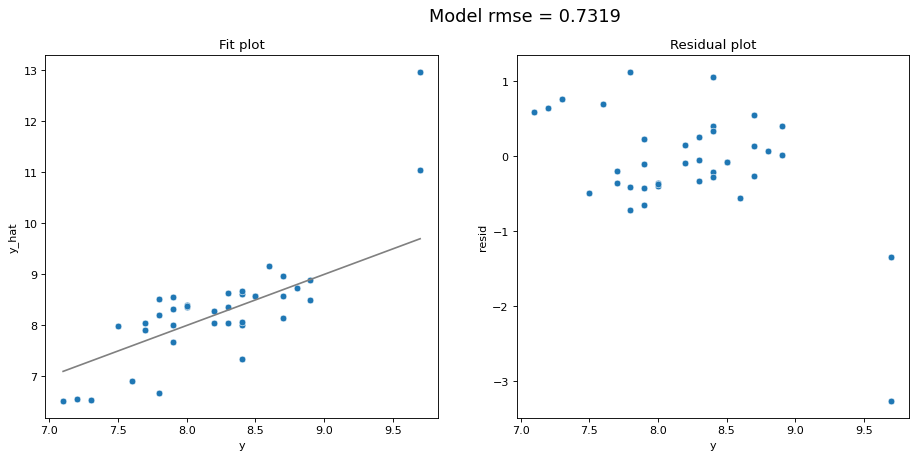

[ 3.50934236e-02  6.93717845e-04  2.43710146e-03 -2.03567004e-03
 -1.04823890e-04  6.26836399e-04 -6.37209172e-02  9.68336522e-13
  5.10553720e-01 -9.40946736e-02  2.88929654e-01  7.89350112e-02
 -5.23985679e-01 -1.40698698e-01 -2.42012390e-01  2.60479363e-01
  1.87849036e-01  6.42748228e-02  8.51337526e-02  1.78498951e-02
  2.85966522e-02  1.55070478e-01  1.42334342e-01  1.07975095e-01
 -4.52450241e-02 -5.14279113e-02 -2.24524490e-02 -9.94194644e-01
  3.49593837e-02  9.21050684e-02 -1.57839393e-01 -4.95434933e-01
  8.11243789e-02  6.57178550e-02  3.66804311e-01  3.32949270e-02
  3.53875362e-01 -5.85472703e-01  1.52365798e-02  6.63055200e-02
 -7.09579543e-02 -2.11086816e-01  5.89415519e-01  5.27355937e-15
  4.76668981e-03 -1.96348379e-01 -5.18603287e-01 -8.60082738e-02
  7.14831194e-02  2.65451561e-01  3.04106954e-01  1.88705705e-01
 -3.78910829e-01 -2.29724344e-01 -7.31067254e-01 -2.81810125e-01
 -1.56221311e-01  7.90841032e-02  6.22742702e-02  3.52114781e-01
  7.28413082e-02  1.05391

In [44]:
# Run the linear reg for dataframe kk (one with directors missing etc)
run_linear_reg(kk)

### Linear regression with standarization

best index:  1
best param:  {'linearregression__fit_intercept': True, 'linearregression__normalize': False}
best score:  551377138354.411
number of coefficients: 112


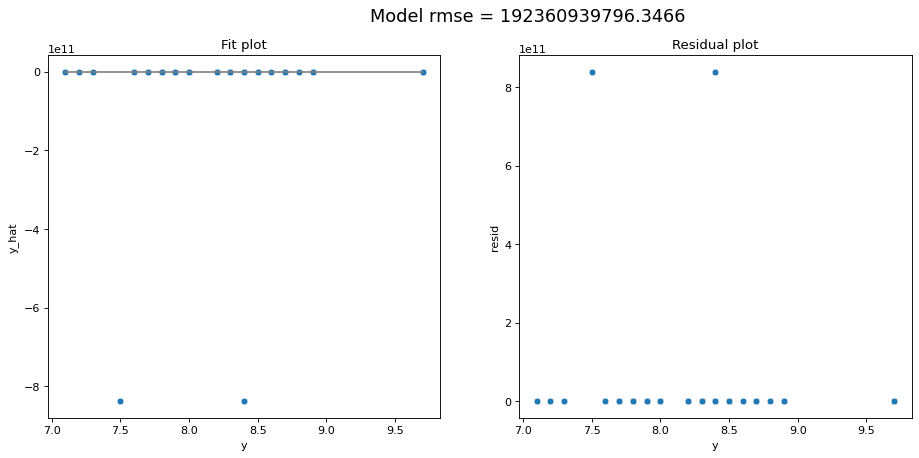

[ 2.52742429e-01  4.43588185e-01  1.98091777e-01 -4.71690018e-02
 -8.29884959e-02  2.60134697e-03 -1.81688889e-02 -1.41714531e+11
  4.45345875e+11 -1.87401852e-02  1.26356249e-01  2.63137990e-02
 -7.37977881e-02 -4.25782118e-02 -1.05840667e-01  7.62597960e-02
  7.98638443e-02  3.16278614e-02  3.94868270e-02  8.22368584e-03
  1.33413740e-02  6.59723152e-02  7.17069014e-02  1.52440850e-02
 -7.13270763e-03 -6.02315647e-03 -3.96271670e-03 -8.11064844e-02
  8.20133944e-03  1.06336467e-02 -1.29331320e-02 -4.02758119e-02
  2.24785092e-02  7.72857666e-03  2.99758911e-02  7.88879395e-03
  4.12750244e-02 -4.80270386e-02  1.12152100e-03  7.57026672e-03
 -1.78909302e-02 -4.78286743e-02  1.06525421e-01 -4.48556691e+08
  1.38854980e-03 -3.53698730e-02 -7.31502771e-02 -2.54821777e-02
  8.39233398e-03  3.73535156e-02  4.29382324e-02  2.64205933e-02
 -4.34913635e-02  1.51490337e+11  1.18161648e+11  9.68106946e+10
  9.68106946e+10  2.19932057e+11  2.00382857e+11  9.68106946e+10
  6.86895352e+10  1.18161

,y,y_hat,resid
106,8.4,-8.384818e+11,8.384818e+11
45,8.9,8.884167e+00,0.000000e+00
158,7.2,6.568615e+00,6.000000e-01
63,7.9,8.320080e+00,-4.000000e-01
135,9.7,1.104286e+01,-1.300000e+00
66,8.3,8.630627e+00,-3.000000e-01
18,8.3,8.360119e+00,-1.000000e-01
109,8.6,9.157605e+00,-6.000000e-01
141,7.3,6.535046e+00,8.000000e-01
7,8.2,8.290799e+00,-1.000000e-01


In [37]:
first_2 = make_pipeline(
         StandardScaler(),
        LinearRegression()
    )

parameters = {"linearregression__fit_intercept" : [True,False],
             'linearregression__normalize': [True,False]}

kf = KFold(n_splits=5, shuffle=True, random_state=0)
first2_grid = GridSearchCV(first_2,parameters,  cv=kf, scoring="neg_root_mean_squared_error").fit(X_train, y_train)


print("best index: ", first2_grid.best_index_) #position of the array of the degree
print("best param: ", first2_grid.best_params_)
print("best score: ", first2_grid.best_score_ *-1)
print("number of coefficients:",len(first2_grid.best_estimator_.named_steps['linearregression'].coef_))

y_hat = first2_grid.predict(X_test)
model_fit(first2_grid, X_test, y_test, plot=True) #compute over test
rmse = mean_squared_error(y_test, y_hat, squared=False)
#print(rmse)
print(first2_grid.best_estimator_.named_steps['linearregression'].coef_)
print("intercept == ",first2_grid.best_estimator_.named_steps['linearregression'].intercept_)

res = pd.DataFrame(
        data = {'y': y_test, 'y_hat': y_hat, 'resid': round(y_test - y_hat,1)}
    )

res

## Polynomial regression

best index:  1
best param:  {'linearregression__fit_intercept': True, 'linearregression__normalize': True, 'polynomialfeatures__degree': 2}
best score:  0.4530011493465141
number of coefficients: 6441


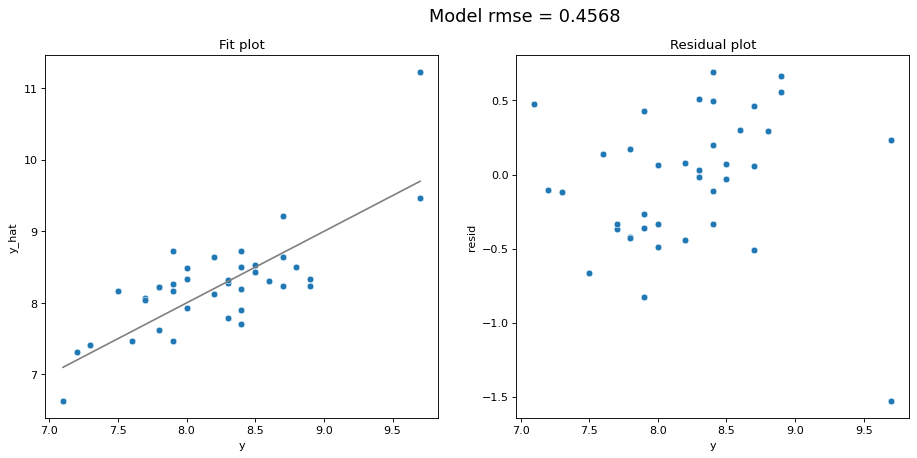

[-7.94757572e-02 -5.16257766e-04  2.24206591e-05 ... -1.15113443e-04
  0.00000000e+00 -5.00600769e-04]
intercept ==  7.43672715130633


In [38]:
second = make_pipeline(
        PolynomialFeatures(),
        LinearRegression()
    )

parameters = {
    'polynomialfeatures__degree': np.arange(1,3,1),
    "linearregression__fit_intercept" : [True,False],
    'linearregression__normalize': [True,False]
}

kf = KFold(n_splits=5, shuffle=True, random_state=0)

second_grid = GridSearchCV(second, parameters, cv=kf, scoring="neg_root_mean_squared_error").fit(X_train, y_train)
print("best index: ", second_grid.best_index_) #position of the array of the degree
print("best param: ", second_grid.best_params_)
print("best score: ", second_grid.best_score_ *-1)
print("number of coefficients:",len(second_grid.best_estimator_.named_steps['linearregression'].coef_))

y_hat = second_grid.predict(X_test)
model_fit(second_grid, X_test, y_test, plot=True)
rmse = mean_squared_error(y_test, y_hat, squared=False)
#print(rmse)
print(second_grid.best_estimator_.named_steps['linearregression'].coef_)
print("intercept == ",second_grid.best_estimator_.named_steps['linearregression'].intercept_)

best index:  1
best param:  {'linearregression__fit_intercept': True, 'linearregression__normalize': True, 'polynomialfeatures__degree': 2}
best score:  0.4530011493465141
number of coefficients: 6441


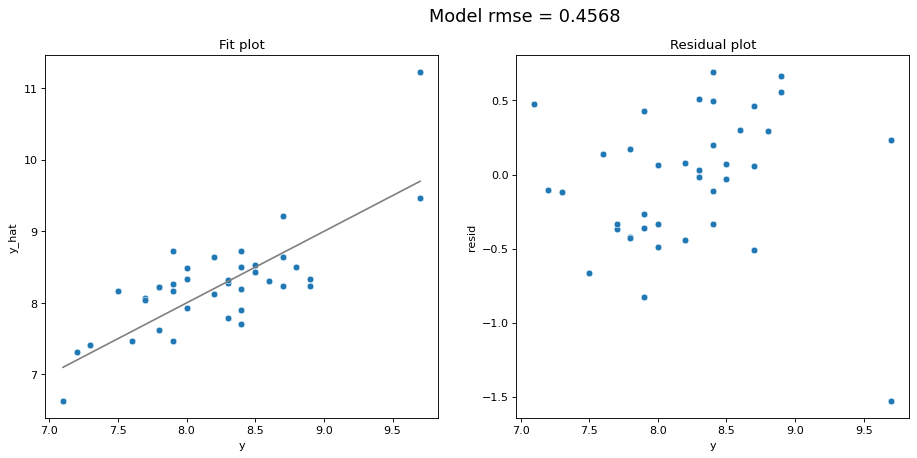

[-7.94757572e-02 -5.16257766e-04  2.24206591e-05 ... -1.15113443e-04
  0.00000000e+00 -5.00600769e-04]
intercept ==  7.43672715130633


In [39]:
second = make_pipeline(
        PolynomialFeatures(),
        LinearRegression()
    )

parameters = {
    'polynomialfeatures__degree': np.arange(1,3,1),
    "linearregression__fit_intercept" : [True,False],
    'linearregression__normalize': [True,False]
}

kf = KFold(n_splits=5, shuffle=True, random_state=0)

second_grid = GridSearchCV(second, parameters, cv=kf, scoring="neg_root_mean_squared_error").fit(X_train, y_train)
print("best index: ", second_grid.best_index_) #position of the array of the degree
print("best param: ", second_grid.best_params_)
print("best score: ", second_grid.best_score_ *-1)
print("number of coefficients:",len(second_grid.best_estimator_.named_steps['linearregression'].coef_))

y_hat = second_grid.predict(X_test)
model_fit(second_grid, X_test, y_test, plot=True)
rmse = mean_squared_error(y_test, y_hat, squared=False)
#print(rmse)
print(second_grid.best_estimator_.named_steps['linearregression'].coef_)
print("intercept == ",second_grid.best_estimator_.named_steps['linearregression'].intercept_)

## Lasso 

In [196]:
lasso_pipe = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(),
        Lasso()
        )
lasso_pipe.get_params()

third_grid.get_params()
third_grid.best_estimator_.get_params#named_steps['PolynomialFeatures'].coef_
third_grid.best_estimator_.named_steps.

PolynomialFeatures(degree=1)

best index:  0
best param:  {'lasso__alpha': 0.1, 'polynomialfeatures__degree': 1, 'polynomialfeatures__include_bias': True}
best score:  0.39071637106401724


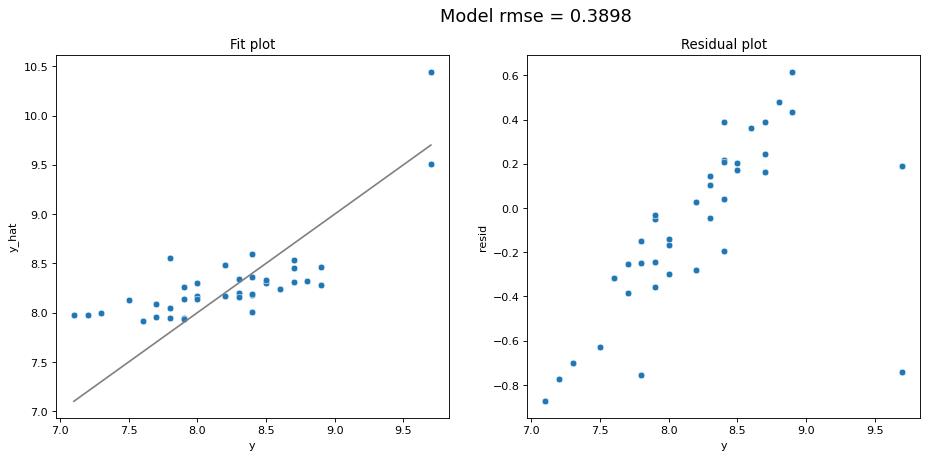

In [201]:
alpha_list = np.linspace(0.1, 15, num=150)

third = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(),
        Lasso()
        
    )

parameters = {
    'polynomialfeatures__degree': np.arange(1,3,1),
     'lasso__alpha': alpha_list,
     'polynomialfeatures__include_bias': [True,False]
}

kf = KFold(n_splits=5, shuffle=True, random_state=0)

third_grid = GridSearchCV(third, parameters, cv=kf, scoring="neg_root_mean_squared_error").fit(X_train, y_train)
print("best index: ", third_grid.best_index_) #position of the array of the degree
print("best param: ", third_grid.best_params_)
print("best score: ", third_grid.best_score_ *-1)
print("number of coefficients:",len(third_grid.best_estimator_.named_steps["lasso"].coef_))


y_hat = third_grid.predict(X_test)
model_fit(third_grid, X_test, y_test, plot=True)
rmse = mean_squared_error(y_test, y_hat, squared=False)
print(rmse)
print("coefficients == ", third_grid.best_estimator_.named_steps["lasso"].coef_)
print("intercept == ", third_grid.best_estimator_.named_steps["lasso"].intercept_)


# step2: initialize the model
#gcv_lasso = GridSearchCV(third, params,cv = kf, scoring= "neg_mean_absolute_error")
# step 3: train the model
#gcv_.fit(X_train, y_train)

## Ridge

best index:  356
best param:  {'polynomialfeatures__degree': 1, 'polynomialfeatures__include_bias': False, 'ridge__alpha': 83.09941949353396}
best score:  0.4122900680007543
number of coefficients: 112


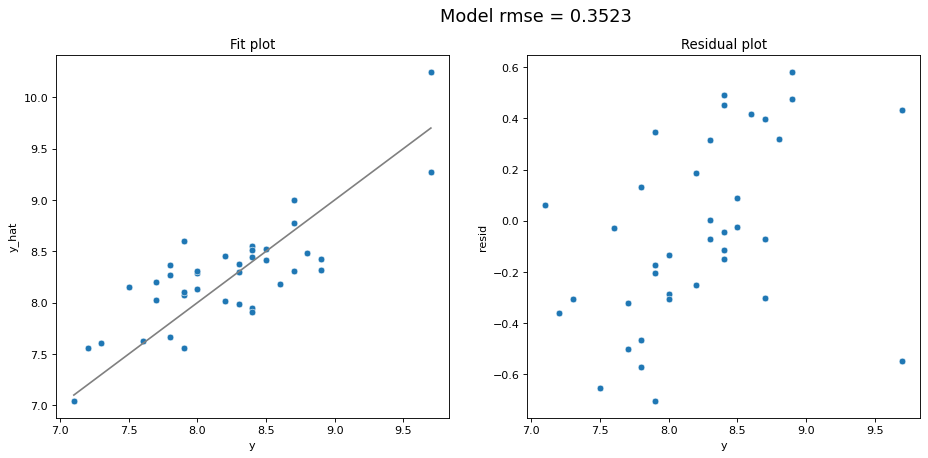

0.35234154860857775
coefficients ==  [ 0.03321482  0.13152318  0.05996561  0.01083037  0.03621697  0.02149541
 -0.02147747  0.          0.03953578 -0.02140062  0.05928995 -0.01283118
  0.00317039 -0.01476346 -0.01144756  0.01720324  0.03286923  0.00486066
  0.00048433 -0.01857791  0.00796056  0.00863535 -0.03345047 -0.00340259
 -0.00896639  0.00964948  0.01486085 -0.05321682 -0.01446303  0.01618641
 -0.00886842 -0.00557156  0.03903766  0.02268864  0.01841584 -0.01035446
  0.00425099 -0.0175374   0.0191691   0.01815739  0.0029978  -0.0212757
 -0.00700399  0.          0.01956298 -0.01312177 -0.04531363 -0.01307543
 -0.0136305   0.03947759  0.00288577  0.03324571 -0.01933051 -0.03545985
 -0.04528353 -0.02860671  0.00149906  0.00930177  0.01488607  0.014988
  0.00596483 -0.01210226 -0.00888457 -0.00933759  0.00308106  0.00586164
  0.          0.00681493 -0.00157473  0.01140739  0.01881374 -0.00065233
 -0.03953578 -0.00162804  0.01019668  0.02458725  0.01772324 -0.00563792
 -0.01473297  0.0

In [14]:
alpha_list = np.logspace(-2, 3, num=200)


fourth = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(),
        Ridge()   
    )

parameters = {
    'polynomialfeatures__degree': np.arange(1,3,1),
     'ridge__alpha': alpha_list,
     'polynomialfeatures__include_bias': [True,False]
}

kf = KFold(n_splits=5, shuffle=True, random_state=0)

fourth_grid = GridSearchCV(fourth, parameters, cv=kf, scoring="neg_root_mean_squared_error").fit(X_train, y_train)
print("best index: ", fourth_grid.best_index_) #position of the array of the degree
print("best param: ", fourth_grid.best_params_)
print("best score: ", fourth_grid.best_score_ *-1)
print("number of coefficients:",len(fourth_grid.best_estimator_.named_steps["ridge"].coef_))

y_hat = fourth_grid.predict(X_test)
model_fit(fourth_grid, X_test, y_test, plot=True)
rmse = mean_squared_error(y_test, y_hat, squared=False)
print(rmse)
print("coefficients == ", fourth_grid.best_estimator_.named_steps["ridge"].coef_)
print("intercept == ", fourth_grid.best_estimator_.named_steps["ridge"].intercept_)



# Dont run the cells below 
I commented them out to stop this happening :D so we can press run and it will be ok

In [ ]:
# m2 = make_pipeline(
#     make_column_transformer(),
#     LinearRegression(fit_intercept=True)
# )

# parameters = {
#     'columntransformer__polynomialfeatures-1__degree': np.arange(1,5,1),
#     'columntransformer__polynomialfeatures-2__degree': np.arange(1,5,1),
#     'columntransformer__polynomialfeatures-3__degree': np.arange(1,5,1),
# }

# kf = KFold(n_splits=5, shuffle=True, random_state=0)

# grid_search = GridSearchCV(m2, parameters, cv=kf, scoring="neg_root_mean_squared_error").fit(X, y)

# fit = m2.fit(X, y)

In [106]:
# alpha_list = uniform(0.1, 10, 100)
# #metrics = ["r2"]#, "neg_mean_absolute_error"]


# m = make_pipeline(
#         PolynomialFeatures(),
#         LinearRegression(fit_intercept=False)
#     )

# parameters = {
#     'polynomialfeatures__degree': np.arange(1,6,1)
# }

# #LinearRegression(fit_intercept=False)
# pipe = Pipeline([
#     ("scaler",StandardScaler()),
#     ("poly",LinearRegression()),
#     ("model", Ridge())#, max_iter = 1000
# ])

# params = {
#     "model__alpha": alpha_list,
#     "poly__fit_intercept" : [True,False],
#     "poly__degree": [1,2,3]
# }

# kf = KFold(5, shuffle=True, random_state=0)

# # step2: initialize the model
# gcv_ridge = GridSearchCV(pipe, params,cv = kf, scoring= "neg_mean_absolute_error")
# # step 3: train the model
# gcv_ridge.fit(X_train, y_train)


TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'LinearRegression()' (type <class 'sklearn.linear_model._base.LinearRegression'>) doesn't

In [124]:
# alpha_list = uniform(0.1, 10, 100)
# #metrics = ["r2"]#, "neg_mean_absolute_error"]

# pipe = Pipeline([
#     ("scaler",StandardScaler()),
#     ("poly", PolynomialFeatures()),#degree=1
#     ("model", Ridge())#, max_iter = 1000
# ])

# params = {
#     "model__alpha": alpha_list,
#     "poly__include_bias" : [True,False],
#     "poly__degree": [1,2]
# }

# kf = KFold(5, shuffle=True, random_state=0)

# # step2: initialize the model
# gcv = GridSearchCV(pipe, params,cv = kf, scoring= "neg_mean_absolute_error")
# # step 3: train the model
# gcv.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# print("best parameters:",gcv.best_params_)
# print("best rmse:",gcv.best_score_)
# gcv.best_estimator_.named_steps["model"].coef_

In [ ]:
# pred = gcv.best_estimator_.predict(X_test)
# sns.scatterplot(
#     x=y_test,
#     y=gcv.best_estimator_.predict(X_test)
# )

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client). If you use any additional data sources, you should introduce them here and discuss why they were included.*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, regression trees, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.*

*For example if you considered a linear regression model, a classification tree, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

## 4. Discussion & Conclusions


*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a NBC Universal executive who is with the show and  university level mathematics but not necessarily someone who has taken a postgraduate statistical modeling course. Your goal should be to convince this audience that your model is both accurate and useful.*

*Finally, you should include concrete recommendations on what NBC Universal should do to make their reunion episode a popular as possible.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

## 5. Convert Document

In [ ]:
# # Run the following to render to PDF
# !jupyter nbconvert --to markdown project1.ipynb

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8d54bbee-a4bc-40dc-a5f1-a0190c0e14b4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>